### Intro

Here is an attempt to implement an idea of using the parallel RNN branches for each asset and use learned information to compute the vector of targets at each timestep.

Steps:
* Fill gaps in the training set like it describer in the competition tutorial notebook;
* Use `TimeseriesGenerator` like generator class to build the dataset;
* Build the model. Simplified  structure:
    - Lambda layer needed for assets separation;
    - Masking layer. Generated records (filled gaps) has zeros as features values, so they are not used in the computations;
    - LSTM or GRU layer;
    - Concatanate layer.

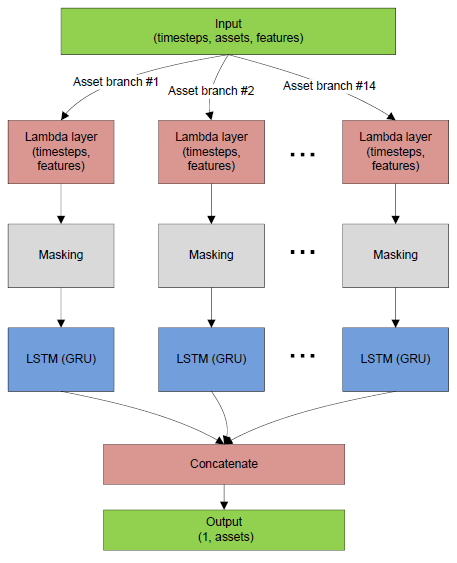


### Load and prepare the data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import gresearch_crypto
import gc

from plotly.subplots import make_subplots
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)

DEBUG = True

In [ ]:
train = pd.read_csv('../input/g-research-crypto-forecasting/train.csv').set_index("timestamp")
assets = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
#for assets sorting 
assets_order = pd.read_csv('../input/g-research-crypto-forecasting/supplemental_train.csv').Asset_ID[:14]
assets_order = dict((t,i) for i,t in enumerate(assets_order))

if DEBUG:
    #train = train[1000000:12000000]
    train = train[10000000:]

train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP','Target']] = \
train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP','Target']].astype(np.float32)

train['Target'] = train['Target'].fillna(0)

In [ ]:
# VWAP column has -inf and inf values. VWAP_max and VWAP_min will be used for replacement
    
VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
print(VWAP_max, "\n", VWAP_min)

train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)

In [ ]:
# Get the series of the 'real' record ids for futher matching
    
df = train[['Asset_ID', 'Target']].copy()

times = dict((t,i) for i,t in enumerate(df.index.unique()))
df['id'] = df.index.map(times)
df['id'] = df['id'].astype(str) + '_' + df['Asset_ID'].astype(str)
ids = df.id.copy()

del df

In [ ]:
def add_features(df):
    df['Upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['Lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    
    df['spread'] = df['High'] - df['Low']
    df['mean_trade'] = df['Volume']/df['Count']
    df['log_price_change'] = np.log(df['Close']/df['Open'])
    return df

train=add_features(train)
train.shape

In [ ]:
scale_features = train.columns.drop(['Asset_ID','Target'])
RS = RobustScaler()
train[scale_features] = RS.fit_transform(train[scale_features])

In [ ]:
# Filling gaps

ind = train.index.unique()

def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df

train=train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
train.shape

In [ ]:
# Matching records and marking generated rows as 'non-real'

train['group_num'] = train.index.map(times)
train = train.dropna(subset=['group_num'])
train['group_num'] = train['group_num'].astype('int')

train['id'] = train['group_num'].astype(str) + '_' + train['Asset_ID'].astype(str)

train['is_real'] = train.id.isin(ids)*1
train = train.drop('id', axis=1)

In [ ]:
# Features values for 'non-real' rows are set to zeros

features = train.columns.drop(['Asset_ID','group_num','is_real'])
train.loc[train.is_real==0, features]=0.

In [ ]:
# Sorting assets according to their order in the 'supplemental_train.csv'

train['asset_order'] = train.Asset_ID.map(assets_order) 
train=train.sort_values(by=['group_num', 'asset_order'])
train.head(20)

In [ ]:
targets = train['Target'].to_numpy().reshape(-1, 14)
#targets = np.expand_dims(targets, axis=1)

features = train.columns.drop(['Asset_ID', 'Target', 'group_num','is_real'])
train = train[features]

train=np.array(train)
train = train.reshape(-1,14,train.shape[-1])
#train = np.expand_dims(train, axis=1)
train.shape

### Dataset creation

Samples with a duration of 15 records (minutes) will be formed from the `train` array. Each sample has a target vector corresponding to the 15th record. 

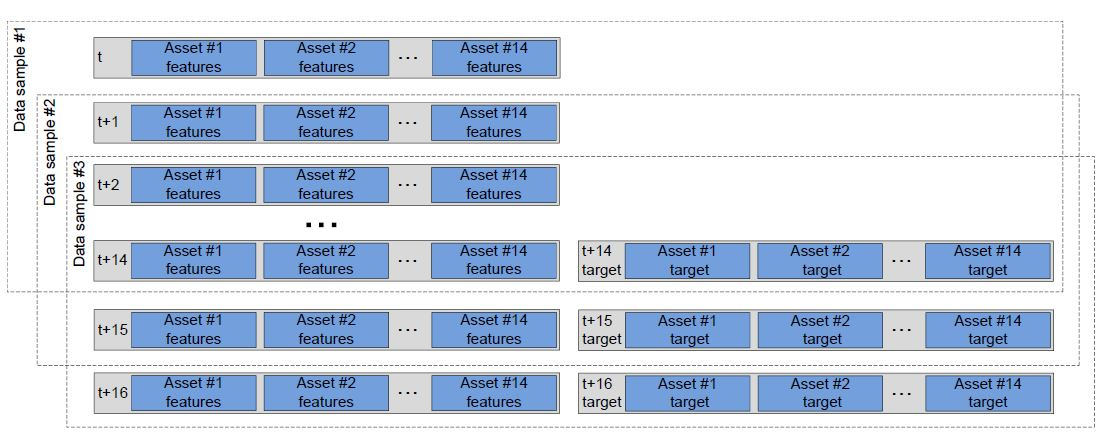

In [ ]:
# timeseriesgenerator-like class, except it using target from the last timestep insteed of last+1
class sample_generator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, length):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.length = length
        self.size = len(x_set)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x=[]
        batch_y=[]
        for i in range(self.batch_size):
            start_ind = self.batch_size*idx + i
            end_ind = start_ind + self.length 
            if end_ind <= self.size:
                batch_x.append(self.x[start_ind : end_ind])
                batch_y.append(self.y[end_ind -1])

        return np.array(batch_x), np.array(batch_y)

In [ ]:
#last 10% of the data are used as validation set
X_train, X_test = train[:-len(train)//10], train[-len(train)//10:]
y_train, y_test = targets[:-len(train)//10], targets[-len(train)//10:]

In [ ]:
BATCH_SIZE=2**10
train_generator = sample_generator(X_train, y_train, length=15, batch_size=BATCH_SIZE)
val_generator = sample_generator(X_test, y_test, length=15, batch_size=BATCH_SIZE)

print(f'Sample shape: {train_generator[0][0].shape}')
print(f'Target shape: {train_generator[0][1].shape}')

### Training

In [ ]:
#https://github.com/tensorflow/tensorflow/issues/37495
def MaxCorrelation(y_true,y_pred):
    """Goal is to maximize correlation between y_pred, y_true. Same as minimizing the negative."""
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return -tf.math.abs(tfp.stats.correlation(y_true_masked,y_pred_masked, sample_axis=None, event_axis=None))

def Correlation(y_true,y_pred):
    return tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))

def masked_mse(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_squared_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_mae(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_absolute_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_cosine(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.cosine_similarity(y_true_masked, y_pred_masked)

def get_model(n_assets=14):  
    x_input = keras.Input(shape=(train_generator[0][0].shape[1], n_assets, train_generator[0][0].shape[-1]))

    branch_outputs = []
        
    for i in range(n_assets):
            # Slicing the ith asset:
        a = layers.Lambda(lambda x: x[:,:, i])(x_input)
        a = layers.Masking(mask_value=0.,)(a)
        a = layers.GRU(units=128, return_sequences=True)(a)
        a = layers.GRU(units=32)(a)
        branch_outputs.append(a)
    
    x = layers.Concatenate()(branch_outputs)
    x = layers.Dense(units=64)(x)
#     x = layers.Dropout(0.2)(x)
    out = layers.Dense(units=n_assets)(x)
    
    model = keras.Model(inputs=x_input, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
                  #loss = 'mse',
                  #loss = 'cosine_similarity',
                  loss = masked_cosine,
                  metrics=[Correlation]
                 )
    
    return model 
    
model=get_model()
#model.summary()

In [ ]:
gc.collect()

In [ ]:
#example with 2 assets for visibility
tf.keras.utils.plot_model(get_model(n_assets=2), show_shapes=True)

In [ ]:
tf.random.set_seed(0)

estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min',restore_best_weights=True)
plateau = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=3, verbose=1, min_lr=1e-8)

epochs_=40
initial_learning_rate=0.008
final_learning_rate=0.00001
ds=(0.5*len(X_train)/BATCH_SIZE)
dr=(final_learning_rate / initial_learning_rate)**(1/epochs_)

scheduler = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=ds, decay_rate=dr)

lr = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
    
history = model.fit(train_generator, validation_data = (val_generator),
              epochs = epochs_, callbacks = [lr])

In [ ]:
gc.collect()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

histories = pd.DataFrame(history.history)

epochs = list(range(1,len(histories)+1))
loss = histories['loss']
val_loss = histories['val_loss']
Correlation = histories['Correlation']
val_Correlation = histories['val_Correlation']

ax[0].plot(epochs, loss, label = 'Train Loss')
ax[0].plot(epochs, val_loss, label = 'Val Loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')

ax[1].plot(epochs, Correlation, label = 'Train Correlation')
ax[1].plot(epochs, val_Correlation, label = 'Val Correlation')
ax[1].set_title('Correlations')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')

fig.show()

In [ ]:
gc.collect()

### The correlation coefficients by asset for the validation data

In [ ]:
predictions = model.predict(val_generator)
predictions.shape

In [ ]:
print('Asset:    Corr. coef.')
print('---------------------')
for i in range(14):
    #drop first 14 values in the y_test, since they are absent in val_generator labels
    y_true = np.squeeze(y_test[14:,i])
    y_pred = np.squeeze(predictions[:,i])
    
    #get non-zero targets (assuming that zeros indicates 'non-real' rows)
    real_target_ind = np.argwhere(y_true!=0)
    asset_id = list(assets_order.keys())[i]
    asset_name = assets[assets.Asset_ID == asset_id]['Asset_Name'].item()
    print(f"{asset_name}: {np.corrcoef(y_pred[real_target_ind].flatten(), y_true[real_target_ind].flatten())[0,1]:.4f}") 

del predictions

### Submission

In [ ]:
#test_df = pd.read_csv('../input/g-research-crypto-forecasting/example_test.csv')
#sample_prediction_df = pd.read_csv('../input/g-research-crypto-forecasting/example_sample_submission.csv')

#test_df = test_df.iloc[2:12]
#sample_prediction_df=sample_prediction_df[sample_prediction_df.row_id.isin(test_df.row_id)]

#scale_features = test_df.columns.drop(['Asset_ID','group_num','row_id'])#test_df.head(3)
#test_df.head()

In [ ]:
#placeholder for first 15 samples
sup=pd.read_csv('../input/g-research-crypto-forecasting/supplemental_train.csv')[:15*14]
placeholder=add_features(sup)
placeholder[scale_features] = RS.transform(placeholder[scale_features])
placeholder['asset_order'] = placeholder.Asset_ID.map(assets_order) 
test_sample = np.array(placeholder[features])
test_sample = test_sample.reshape(-1,14,test_sample.shape[-1])
test_sample = np.expand_dims(test_sample, axis=0)
test_sample.shape

In [ ]:
# for test gap filling
example = pd.read_csv('../input/g-research-crypto-forecasting/example_test.csv')[:14]
example['asset_order'] = example.Asset_ID.map(assets_order) 
example = example[['Asset_ID','asset_order']]
example

In [ ]:
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
        
    test_df['VWAP'] =np.nan_to_num(test_df.VWAP, posinf=VWAP_max, neginf=VWAP_min)
    test_df=add_features(test_df)
    test_df[scale_features] = RS.transform(test_df[scale_features])
    
    test_data = test_df.merge(example, how='outer', on='Asset_ID').sort_values('asset_order')
        
    test = np.array(test_data[features].fillna(0))
    test = test.reshape(-1,1,14,test.shape[-1])
        #get test sample, shape (1, 15, 14, test.shape[-1])
    test_sample = np.hstack([test_sample, test])[:,-15:]
    y_pred = model.predict(test_sample).squeeze().reshape(-1, 1).squeeze()
    
    test_data['Target'] = y_pred
        
    #test_df = test_df.merge(test_data[['row_id', 'Target']], how='left', on='row_id')
    for _, row in test_df.iterrows(): 
        try:
            sample_prediction_df.loc[sample_prediction_df['row_id'] == row['row_id'], 'Target'] = test_data.loc[test_data['row_id'] == row['row_id'], 'Target'].item()
        except:
            sample_prediction_df.loc[sample_prediction_df['row_id'] == row['row_id'], 'Target'] = 0
       
    #sample_prediction_df['Target'] = test_df['Target']
    #display(test_df)
    #display(test_data)
    #display(sample_prediction_df)    
    env.predict(sample_prediction_df)